In [2]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil
import dask.dataframe as dd
from dask.delayed import delayed

In [3]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#### Baseline

In [135]:
cols_to_use = ['IDMerged', 'tripIndex', 'actStartTime', 'actEndTime','duration_travelling', 'cost_BEAM', 'actStartType', 
               'actEndType', 'duration_walking', 'duration_in_privateCar', 'duration_on_bike', 'duration_in_ridehail', 
              'distance_travelling', 'duration_in_transit', 'distance_walking','distance_bike','distance_ridehail', 
              'distance_privateCar', 'distance_transit', 'mode_choice_planned_BEAM','mode_choice_actual_BEAM',
              'vehicleIds', 'distance_mode_choice', 'replanning_status', 'reason', 'fuel_marginal','BlockGroupStart',
              'startX', 'startY', 'bgid_start', 'tractid_start', 'juris_name_start', 'county_name_start', 'mpo_start', 
               'BlockGroupEnd', 'endX', 'endY', 'bgid_end', 'tractid_end', 'juris_name_end', 'county_name_end', 'mpo_end', 
               'emission_marginal', 'duration_door_to_door', 'waitTime_no_replanning', 'waitTime_replanning', 'actPurpose', 
               'mode_choice_actual_6', 'mode_choice_actual_5', 'mode_choice_actual_4', 'trip_mode_AS_trips', 'logsum_trip_Potential_INEXUS',
               'age', 'income', 'hh_cars', 'TAZ_x', 'origin_x', 'destination_x', 'TAZ_y', 'home_taz', 'auto_ownership', 'home_is_urban', 'home_is_rural', 'DRIVEALONEFREE',
               'DRIVEALONEPAY', 'SHARED2FREE', 'SHARED2PAY', 'SHARED3FREE', 'SHARED3PAY', 'WALK', 'BIKE', 'WALK_LOC', 'WALK_LRF', 
               'WALK_EXP', 'WALK_HVY', 'WALK_COM', 'DRIVE_LOC', 'DRIVE_LRF', 'DRIVE_EXP', 'DRIVE_HVY', 'DRIVE_COM', 'TAXI',
               'TNC_SINGLE', 'TNC_SHARED', 'income_quartiles', 'income_deciles' ] # Specify the columns to read

In [268]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay_baseline_30pct_20230218/inexus/sfbay_baseline_default-1.0_2019__20230217.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key) 
sfbase = pd.read_csv(obj['Body'], compression = 'gzip', usecols = cols_to_use)

<timed exec>:4: DtypeWarning: Columns (27,234,235) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 7min 13s
Wall time: 7min 13s


In [6]:
#%%time
#sfbase_dd = dd.read_csv('s3://beam-outputs/pilates-outputs/sfbay_baseline_30pct_20230218/inexus/sfbay_baseline_default-1.0_2019__20230217.csv.gz',
                        #compression = 'gzip', usecols = cols_to_use, blocksize=None)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
#mixed_columns = sfbase_dd.select_dtypes(include=['object']).columns
#print("Columns with mixed types:", mixed_columns)

#### Checking INEXUS plots

In [11]:
# Add the mandatory category column
mandatory = ['work' , 'univ', 'school']
sfbase['mandatoryCat'] = np.where((sfbase.actEndType.isin(mandatory)) & (sfbase.actStartType.isin(mandatory)), 'from_M_to_M' , None)

In [12]:
sfbase['mandatoryCat'] = np.where((sfbase.actEndType == 'Home') & (sfbase.actStartType.isin(mandatory)), 'from_H_to_M' , sfbase['mandatoryCat'])

In [13]:
sfbase['mandatoryCat'] = np.where((sfbase.actEndType.isin(mandatory)) & (sfbase.actStartType == "Home"), 'from_M_to_H' , sfbase['mandatoryCat'])

In [14]:
non_mandatory = ['othmaint' , 'othdiscr', 'escort', 'eatout', 'social', 'shopping', 'atwork']
sfbase['mandatoryCat'] = np.where((sfbase.actEndType.isin(non_mandatory)) & (sfbase.actStartType.isin(non_mandatory)), 'from_N_to_N' , sfbase['mandatoryCat'])

In [16]:
a = sfbase[(sfbase['income_deciles']=='1stD')|(sfbase['income_deciles']=='10thD')]

In [17]:
d = a[(a['mandatoryCat']=='from_M_to_M')|(a['mandatoryCat']=='from_M_to_H')|(a['mandatoryCat']=='from_H_to_M')]

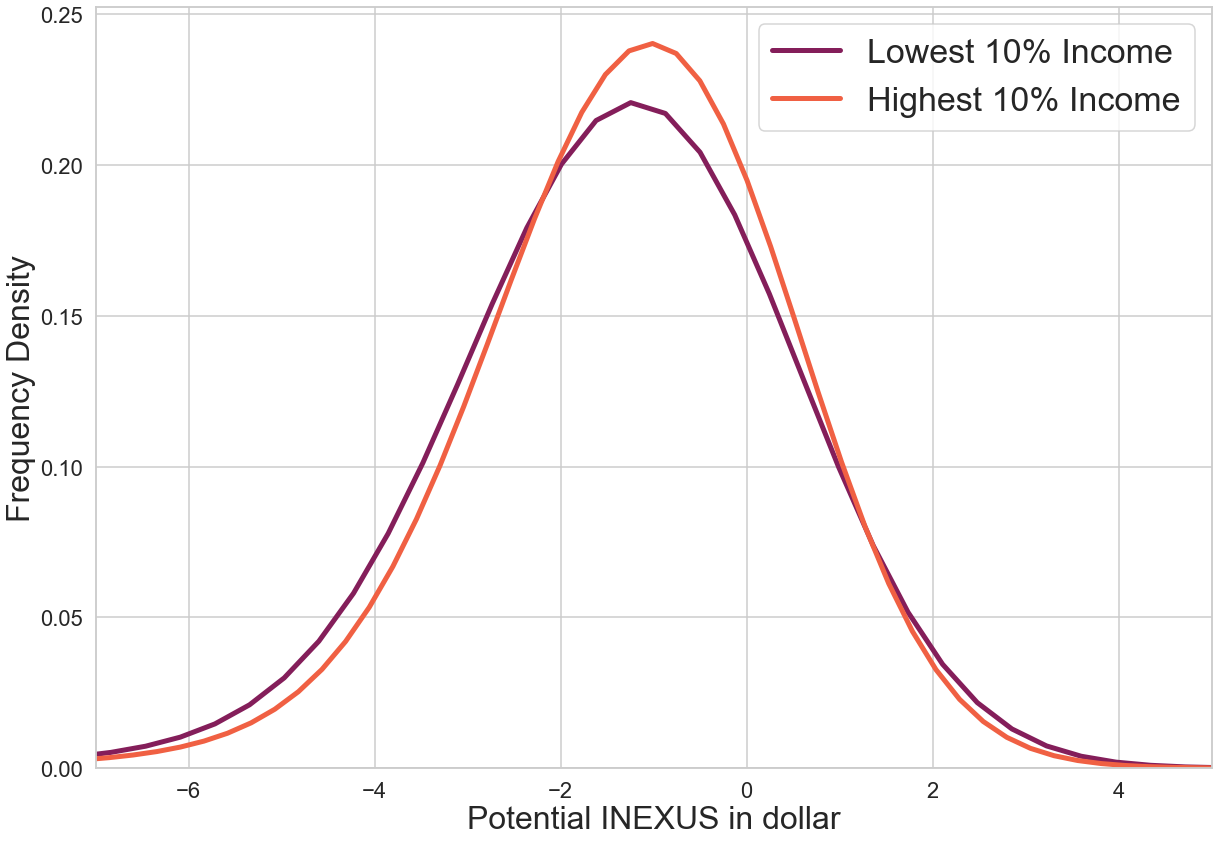

In [18]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=d, x="logsum_trip_Potential_INEXUS", hue = 'income_deciles',
            fill=False, common_norm=False, alpha=1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-7, 5)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [21]:
a.describe()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,distance_mode_choice,replanning_status,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,logsum_trip_Potential_INEXUS,age,TAZ_x,home_taz,income,auto_ownership,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED
count,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482334e+06,1.482357e+06,1.482357e+06,1.482334e+06,1.482334e+06,1.482258e+06,1.482357e+06,1.482357e+06,1.482258e+06,1.482258e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06
mean,3.333569e+06,1.093411e+09,5.151063e+04,5.021855e+04,1.218407e+03,1.069786e+00,6.369524e+02,4.789224e+02,1.260355e+01,6.526253e+00,1.057794e+04,8.338990e+01,8.233868e+02,6.301781e+01,1.157486e+02,8.955491e+03,6.201785e+02,1.047325e+04,2.286336e-02,1.128230e+07,6.055026e+10,-1.221816e+02,3.770783e+01,6.055026e+10,6.055026e+09,6.055034e+10,-1.221815e+02,3.770779e+01,6.055034e+10,6.055034e+09,1.859792e-06,1.292085e+03,6.672059e+01,6.958195e+00,-6.088286e-01,4.098165e+01,7.211187e+02,7.211187e+02,1.948494e+05,2.012095e+00,-3.868384e+02,-3.877092e+02,-4.598362e+02,-4.607049e+02,-6.576726e+02,-6.585405e+02,-2.802974e+01,-1.051578e+03,-1.043146e+03,-1.866363e+03,-1.893134e+03,-1.875991e+03,-1.891875e+03,-1.886254e+03,-2.168340e+03,-2.168542e+03,-2.168363e+03,-2.168528e+03,-1.427012e+01,-1.440940e+01,-1.213774e+01
std,1.915194e+06,6.281837e+08,1.666818e+04,1.640426e+04,2.075488e+03,1.826527e+00,1.981720e+03,5.912613e+02,1.225589e+02,8.318869e+01,1.217806e+04,4.031061e+02,2.694670e+03,6.127931e+02,1.532463e+03,1.188557e+04,3.493152e+03,1.256023e+04,2.135210e-01,1.781668e+07,3.708118e+08,2.548852e-01,3.132093e-01,3.708118e+08,3.708118e+07,3.708758e+08,2.552218e-01,3.133370e-01,3.708758e+08,3.708758e+07,5.485502e-05,2.212987e+03,6.650103e+02,8.338581e+01,1.326919e+00,2.229999e+01,4.255560e+02,4.255560e+02,2.010716e+05,9.411548e-01,5.810046e+02,5.814163e+02,4.976485e+02,4.987379e+02,4.730912e+02,4.742204e+02,5.182647e+01,2.720911e+02,4.901367e+02,4.099332e+02,3.068735e+02,3.758636e+02,3.123733e+02,5.861314e+02,3.788524e+02,3.781422e+02,3.795586e+02,3.782332e+02,1.339521e+01,1.302423e+01,1.143374e+01
min,1.200000e+01,3.985000e+03,0.000000e+00,1.800000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00,0.000000e+00,6.001400e+10,-1.235231e+02,3.693327e+01,6.001400e+10,6.001400e+09,6.001400e+10,-1.235272e+02,3.693146e+01,6.001400e+10,6.001400e+09,0.000000e+00,-2.139870e+05,-2.139870e+05,0.000000e+00,-7.579218e+01,0.000000e+00,1.000000e+00,1.000000e+00,-1.460000e+04,0.000000e+00,-3.028670e+03,-3.028692e+03,-2.011008e+03,-2.011025e+03,-1.043049e+03,-2.010572e+03,-1.280538e+03,-3.063225e+03,-2.000814e+03,-2.010057e+03,-1.999053e+03,-2.010344e+03,-2.007656e+03,-3.999179e+03,-3.998038e+03,-3.996433e+03,-4.003404e+03,-3.998907e+03,-2.896412

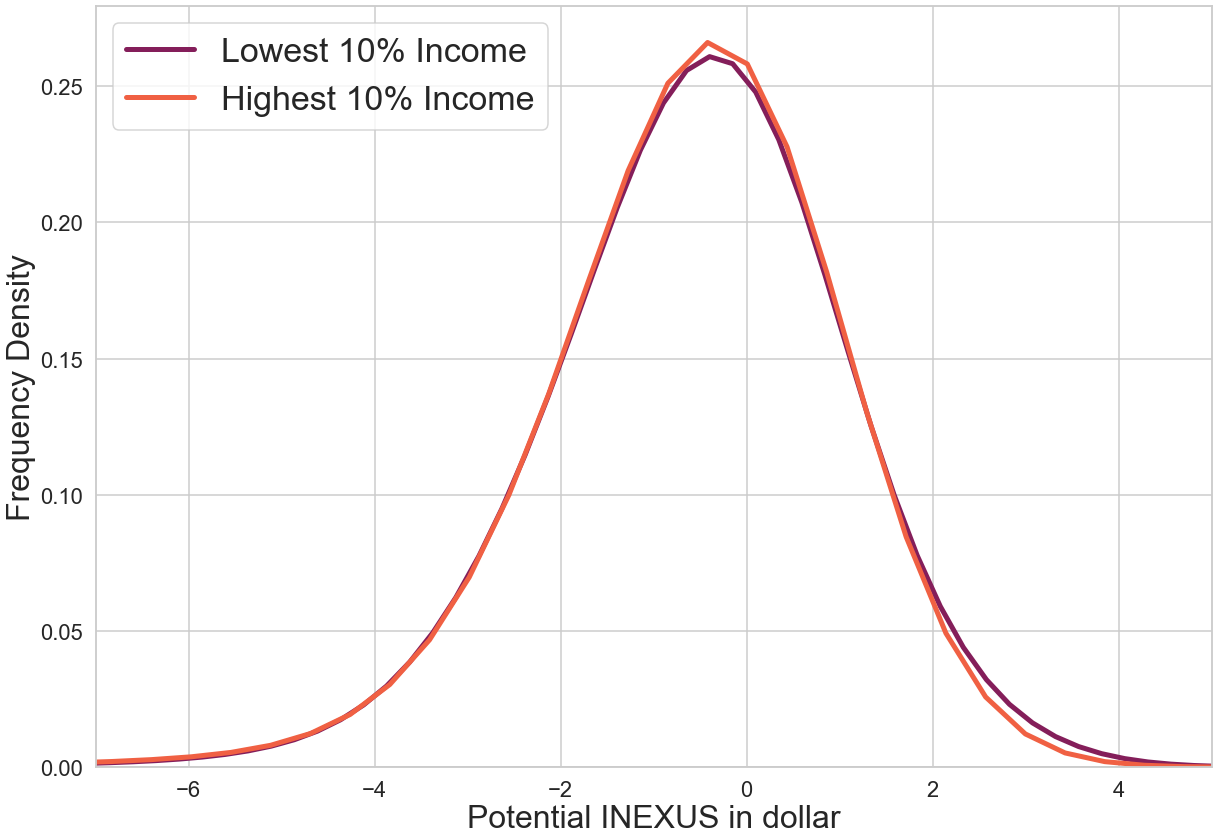

In [19]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid")


ax=sns.kdeplot(data=a, x="logsum_trip_Potential_INEXUS", hue = 'income_deciles',
            fill=False, common_norm=False, alpha=1, palette=sns.color_palette('rocket_r', n_colors=2), bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

plt.xlim(-7, 5)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [23]:
d.groupby(['income_deciles'])['logsum_trip_Potential_INEXUS'].describe()

,count,mean,std,min,25%,50%,75%,max
income_deciles,,,,,,,,
10thD,245630.0,-1.253547,1.262793,-40.124264,-1.918634,-1.052633,-0.357821,2.808883
1stD,172676.0,-1.385187,1.337012,-62.881695,-2.015703,-1.248532,-0.468343,2.636796


C:\Users\nazanin\.conda\envs\geo_env\lib\site-packages\dask\dataframe\io\csv.py:178: DtypeWarning: Columns (27,234,235) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


In [22]:
a.groupby(['income_deciles'])['logsum_trip_Potential_INEXUS'].describe()

,count,mean,std,min,25%,50%,75%,max
income_deciles,,,,,,,,
10thD,747149.0,-0.580415,1.322031,-40.124264,-1.234267,-0.365663,0.154460,2.867913
1stD,735223.0,-0.637703,1.331247,-75.792184,-1.220262,-0.388681,0.156975,2.771798


#### Checking the cost of walk trips

In [37]:
sfbase[sfbase['mode_choice_actual_BEAM']=='walk'].head(2)

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
103,254,83562,67553.0,63593.0,3960.0,0.0,escort,escort,3960.0,0.0,0.0,0.0,5147.991,0.0,5147.991,0.0,0.0,0.0,0.0,body-254,walk,walk,body-254,1.0,5147.991,0,NaN,NaN,0,0,0,0,0,0,272843.523,0.0,0.0,0.0,0.0,0.0,272843.523,6.013354

In [36]:
sfbase[(sfbase['mode_choice_actual_BEAM']=='walk')&(sfbase['cost_BEAM']==0)&
       (sfbase['mode_choice_planned_BEAM']!='walk')].head(2)

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles
3151,8032,2634815,85455.0,72605.0,12850.0,0.0,Home,othmaint,12850.0,0.0,0.0,0.0,17729.676751,0.0,17729.676751,0.0,0.0,0.0,0.0,"body-8032,SF:7625053,body-8032,BA:59DCM11,body...",walk_transit,walk,body-8032,"1.0, 1.0, 1.0, 1.0

In [38]:
sfbase[(sfbase['mode_choice_actual_BEAM']=='walk')&(sfbase['cost_BEAM']!=0)].to_csv('C:/Shared-Work/Data/CleanData/walk_cost.csv', index = False)

#### Checking the ridehail pooled and solo statistics

In [576]:
sfbase[(sfbase['mode_choice_planned_BEAM'] == 'ride_hail')|(sfbase['mode_choice_planned_BEAM'] == 'ride_hail_pooled')].shape

(52363, 269)

In [577]:
sfbase[sfbase['mode_choice_planned_BEAM'] == "ride_hail_pooled"].shape 

(9516, 269)

In [578]:
sfbase['pooled_success'] = np.where((sfbase['mode_choice_planned_BEAM'] == sfbase['mode_choice_actual_BEAM'])&
                                    (sfbase['mode_choice_planned_BEAM'] == 'ride_hail_pooled'), 1, 0)

In [579]:
sfbase[sfbase['pooled_success'] == 1].shape

(4545, 270)

In [580]:
sfbase['ridehail_success'] = np.where((sfbase['mode_choice_planned_BEAM'] == sfbase['mode_choice_actual_BEAM'])&
                                    (sfbase['mode_choice_planned_BEAM'] == 'ride_hail'), 1, 0)

In [581]:
sfbase[sfbase['mode_choice_planned_BEAM'] == "ride_hail"].shape 

(42847, 271)

In [582]:
sfbase[sfbase['ridehail_success'] == 1].shape

(27533, 271)

####  Ridehail pooled riders match

In [22]:
sfbase.shape

(7435159, 83)

In [248]:
pooled.shape

(4545, 270)

In [249]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == "ride_hail_pooled")|(sfbase['mode_choice_actual_BEAM'] == "ride_hail")].shape

(32412, 269)

In [275]:
pooled = sfbase[sfbase['mode_choice_actual_BEAM'] == "ride_hail_pooled"]

In [276]:
pooled['group'] = pooled['vehicleIds'].str.extract(r'(rideHail.*)')

C:\Users\nazanin\AppData\Local\Temp\2\ipykernel_8736\2292529406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pooled['group'] = pooled['vehicleIds'].str.extract(r'(rideHail.*)')


In [277]:
pooled['group'] = pooled['group'].str.split(',').str[0]

C:\Users\nazanin\AppData\Local\Temp\2\ipykernel_8736\2724310920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pooled['group'] = pooled['group'].str.split(',').str[0]


In [278]:
#pooled['end_time'] = pd.to_datetime(pooled['actStartTime'], unit='s')
#pooled['start_time'] = pd.to_datetime(pooled['actEndTime'], unit='s')

In [279]:
#pooled['start_time'] = pooled['start_time'].dt.time

In [280]:
#pooled['end_time'] = pooled['end_time'].dt.time

In [281]:
pooled = pooled.sort_values(['actEndTime', 'actStartTime'], ascending=[True, False])

In [282]:
%%time
mutual_pooled = pd.pivot_table(
   pooled,
   index=['group'],
   aggfunc={'IDMerged': lambda x: ', '.join(list(x.dropna().astype(str))),
            'tripIndex': lambda x: ', '.join(list(x.dropna().astype(str))),
            'actPurpose': lambda x: ', '.join(list(x.dropna().astype(str))),
            'mode_choice_planned_BEAM': lambda x: ', '.join(list(x.dropna().astype(str))),
            'mode_choice_actual_BEAM': lambda x: ', '.join(list(x.dropna().astype(str))),
            'actStartTime': lambda x: ', '.join(list(x.dropna().astype(str))),
            'actEndTime': lambda x: ', '.join(list(x.dropna().astype(str)))}).reset_index() 

CPU times: total: 1.19 s
Wall time: 1.16 s


In [283]:
mutual_pooled.head()

,group,IDMerged,actEndTime,actPurpose,actStartTime,mode_choice_actual_BEAM,mode_choice_planned_BEAM,tripIndex
0,rideHailVehicle-1007433@Uber,"923408, 600180, 486348","60713.0, 60900.0, 63671.0","othmaint_to_Home, shopping_to_Home, othmaint_t...","61754.0, 62845.0, 64111.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","302878053, 196859309, 159522381"
1,rideHailVehicle-1013349@Lyft,"1599568, 1599568, 1620634","21024.0, 22324.0, 24768.0","Home_to_othdiscr, othdiscr_to_Home, Home_to_work","22174.0, 23633.0, 26318.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","524658505, 524658509, 531568265"
2,rideHailVehicle-1017430@Uber,1215476,29379.0,Home_to_shopping,32282.0,ride_hail_pooled,ride_hail_pooled,398678905
3,rideHailVehicle-1023032@Uber,"1014815, 5948265, 4659245, 5932906","18090.0, 25790.0, 33354.0, 34628.0","Home_to_escort, Home_to_work, Home_to_othdiscr...","18541.0, 26526.0, 34509.0, 36342.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","332859393, 1951031233, 1528232561, 1945993393"
4,rideHailVehicle-1029101@Lyft,"3214829, 3131730","38905.0, 38955.0","Home_to_othmaint, Home_to_othmaint","40190.0, 39706.0","ride_hail_pooled, ride_hail_pooled","ride_hail_pooled, ride_hail_pooled","1054464137, 1027207665"


In [225]:
def get_shared_persons(row):
    persons = row['IDMerged'].split(', ')
    start_times = [float(x) for x in row['actEndTime'].split(', ')]
    end_times = [float(x) for x in row['actStartTime'].split(', ')]
    shared_persons = []
    for i in range(len(persons)):
        for j in range(i+1, len(persons)):
            if start_times[i] <= end_times[j] and start_times[j] <= end_times[i]:
                shared_persons.append((persons[i], persons[j]))
    return shared_persons

In [284]:
def get_shared_trips(row):
    persons = row['tripIndex'].split(', ')
    start_times = [float(x) for x in row['actEndTime'].split(', ')]
    end_times = [float(x) for x in row['actStartTime'].split(', ')]
    shared_pairs = set()
    for i in range(len(persons)):
        for j in range(i+1, len(persons)):
            if start_times[i] <= end_times[j] and start_times[j] <= end_times[i]:
                shared_pairs.add(frozenset([persons[i], persons[j]]))
    shared_persons = set()
    for pair in shared_pairs:
        group = set(pair)
        for i in range(len(persons)):
            if persons[i] in group:
                continue
            overlaps = True
            for person in group:
                if start_times[i] > end_times[persons.index(person)] or end_times[i] < start_times[persons.index(person)]:
                    overlaps = False
                    break
            if overlaps:
                group.add(persons[i])
        shared_persons.add(tuple(sorted(group)))
    return shared_persons

In [285]:
mutual_pooled['shared_trip_pairs'] = mutual_pooled.apply(get_shared_trips, axis=1)

In [286]:
def count_shared_pairs(x, pairs):
    return len([p for p in pairs if p in x])

In [287]:
all_pairs = set(mutual_pooled['shared_trip_pairs'].explode())
mutual_pooled['shared_trip_count'] = mutual_pooled['shared_trip_pairs'].apply(lambda x: count_shared_pairs(all_pairs, x))

In [288]:
mutual_pooled.tail()

,group,IDMerged,actEndTime,actPurpose,actStartTime,mode_choice_actual_BEAM,mode_choice_planned_BEAM,tripIndex,shared_trip_pairs,shared_trip_count
1893,rideHailVehicle-972250@Uber,"3910620, 5845419, 3604955, 3051058","48254.0, 48326.0, 52381.0, 54468.0","othmaint_to_Home, Home_to_othmaint, shopping_t...","49545.0, 49136.0, 54594.0, 55095.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","1282683589, 1917297657, 1182425509, 1000747249","{(1282683589, 1917297657), (1000747249, 118242...",2
1894,rideHailVehicle-978015@Uber,"623979, 549144, 926374, 4883843, 5143692","38209.0, 38991.0, 41880.0, 45460.0, 45460.0","shopping_to_Home, Home_to_eatout, Home_to_othm...","39069.0, 40429.0, 43510.0, 46525.0, 46335.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","204665342, 180119497, 303850897, 1601900705, 1...","{(180119497, 204665342), (1601900705, 16871312...",2
1895,rideHailVehicle-980128@Lyft,"541256, 612807, 265892","66571.0, 69897.0, 73011.0","Home_to_eatout, escort_to_Home, Home_to_othdiscr","67308.0, 70414.0, 73938.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","177532201, 201000773, 87212865",{},0
1896,rideHailVehicle-983163@Uber,"1926570, 2159820","67485.0, 75513.0","Home_to_shopping, shopping_to_Home","70908.0, 76962.0","ride_hail_pooled, ride_hail_pooled","ride_hail_pooled, ride_hail_pooled","631915113, 708425053",{},0
1897,rideHailVehicle-986278@Uber,"1085804, 1100524","64706.0, 65037.0","Home_to_othmaint, Home_to_shopping","65321.0, 65792.0","ride_hail_pooled, ride_hail_pooled","ride_hail_pooled, ride_hail_pooled","356143937, 360972137","{(356143937, 360972137)}",1


In [289]:
mutual_pooled[mutual_pooled['shared_trip_count']>0].shape

(739, 10)

In [290]:
mutual_pooled['shared_trip_count'].sum()

961

In [265]:
mutual_pooled.shape

(1898, 10)

In [266]:
pooled.shape

(4545, 270)

In [267]:
mutual_pooled.head()

,group,IDMerged,actEndTime,actPurpose,actStartTime,mode_choice_actual_BEAM,mode_choice_planned_BEAM,tripIndex,shared_person_pairs,shared_person_count
0,rideHailVehicle-1007433@Uber,"923408, 600180, 486348","60713.0, 60900.0, 63671.0","othmaint_to_Home, shopping_to_Home, othmaint_t...","61754.0, 62845.0, 64111.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","302878053, 196859309, 159522381","{(196859309, 302878053)}",1
1,rideHailVehicle-1013349@Lyft,"1599568, 1599568, 1620634","21024.0, 22324.0, 24768.0","Home_to_othdiscr, othdiscr_to_Home, Home_to_work","22174.0, 23633.0, 26318.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","524658505, 524658509, 531568265",{},0
2,rideHailVehicle-1017430@Uber,1215476,29379.0,Home_to_shopping,32282.0,ride_hail_pooled,ride_hail_pooled,398678905,{},0
3,rideHailVehicle-1023032@Uber,"1014815, 5948265, 4659245, 5932906","18090.0, 25790.0, 33354.0, 34628.0","Home_to_escort, Home_to_work, Home_to_othdiscr...","18541.0, 26526.0, 34509.0, 36342.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","332859393, 1951031233, 1528232561, 1945993393",{},0
4,rideHailVehicle-1029101@Lyft,"3214829, 3131730","38905.0, 38955.0","Home_to_othmaint, Home_to_othmaint","40190.0, 39706.0","ride_hail_pooled, ride_hail_pooled","ride_hail_pooled, ride_hail_pooled","1054464137, 1027207665","{(1027207665, 1054464137)}",1


In [270]:
mutual_pooled[mutual_pooled['group']=='rideHailVehicle-1934875@Uber']

,group,IDMerged,actEndTime,actPurpose,actStartTime,mode_choice_actual_BEAM,mode_choice_planned_BEAM,tripIndex,shared_person_pairs,shared_person_count
261,rideHailVehicle-1934875@Uber,"1255664, 1244065, 141574, 748614, 141574","19447.0, 19479.0, 22190.0, 23112.0, 23264.0","Home_to_social, Home_to_work, Home_to_othdiscr...","20788.0, 22241.0, 23114.0, 23853.0, 23539.0","ride_hail_pooled, ride_hail_pooled, ride_hail_...","ride_hail_pooled, ride_hail_pooled, ride_hail_...","411858081, 408053633, 46436393, 245545705, 464...","{(245545705, 46436394), (408053633, 411858081)...",4


In [291]:
mutual_pooled.to_csv('C:/Shared-Work/Data/CleanData/rider_count.csv', index = False)

In [55]:
#mutual_pooled = mutual_pooled.drop(['comma_count'], axis=1)

In [56]:
#mutual_pooled['comma_count'] = mutual_pooled['IDMerged'].str.count(',')

In [57]:
#df2 = pd.DataFrame(mutual_pooled['IDMerged'].str.split(',').values.tolist())
#df2.columns += 1
#df2 = df1.add_prefix('person_')

In [591]:
#mutual_pooled = mutual_pooled.join(mutual_pooled['actEndTime'].str.split(',', expand=True).add_prefix('endT_').fillna(np.nan))

In [592]:
#mutual_pooled = mutual_pooled.join(mutual_pooled['actStartTime'].str.split(',', expand=True).add_prefix('startT_').fillna(np.nan))

In [593]:
#mutual_pooled = mutual_pooled.join(mutual_pooled['IDMerged'].str.split(',', expand=True).add_prefix('person_').fillna(np.nan))

In [594]:
# convert the startT_1, startT_0, and endT_0 columns to numeric, and handle NaN values
#endT_columns = [col for col in mutual_pooled.columns if col.startswith("endT_")]

#for col in endT_columns:
    #mutual_pooled[col] = pd.to_numeric(mutual_pooled[col], errors='coerce')

In [595]:
#startT_columns = [col for col in mutual_pooled.columns if col.startswith("startT_")]

#for col in startT_columns:
    #mutual_pooled[col] = pd.to_numeric(mutual_pooled[col], errors='coerce')

In [597]:
# create an empty list to store mutual riders
#mutual_riders = []

# loop through each row of the dataframe
#for i, row in mutual_pooled.iterrows():
    # create a list to store the mutual riders for this row
    #this_row_riders = [] 
    # loop through each pair of persons
    #for j in range(11):
        #for k in range(j+1, 11):
            # check if the time intervals overlap
            #if (row[f'endT_{k}'] <= row[f'startT_{j}'] and row[f'startT_{j}'] >= row[f'endT_{k}']) or (row[f'endT_{k}'] <= row[f'startT_{j}'] and row[f'startT_{k}'] >= row[f'endT_{j}']):
                # if the intervals overlap, add both persons to the mutual_riders list
                #this_row_riders.extend([row[f'person_{j}'], row[f'person_{k}']])
    
    # remove any duplicates from the list of mutual riders and join the remaining rider ids into a single string
    #this_row_mutual_riders = ', '.join(set(this_row_riders))
    
    # add the mutual riders string as a new column to the data frame
    #mutual_pooled.loc[i, 'mutual_riders'] = this_row_mutual_riders

In [598]:
#mutual_pooled['rider_count'] = mutual_pooled['mutual_riders'].str.count(',')+1

In [554]:
# Select columns that start with 'startT_' or 'endT_'
#cols_to_drop = mutual_pooled.filter(regex='^startT_|^endT_|^person_').columns

# Drop the selected columns from the DataFrame
#mutual_pooled = mutual_pooled.drop(columns=cols_to_drop)

In [555]:
mutual_pooled.to_csv('C:/Shared-Work/Data/CleanData/rider_count.csv', index = False)

#### rest of the stacked code

In [7]:
# Adding scenario info
sfbase['scenario'] = "baseline"
sfbase['scenario'] = sfbase['scenario'].astype("category")
sfbase['lever'] = "default"
sfbase['lever'] = sfbase['lever'].astype("category")
sfbase['year'] = 2018
sfbase['lever_position_fltsz'] = 1
sfbase['lever_position_price'] = 1
sfbase['lever_n_fleets'] = 2
sfbase['fleetsize_uber'] = 0.00287777
sfbase['fleetsize_lyft'] = 0.00184043
sfbase['fleetsize_cruise'] = 0
sfbase['fleetsize_flywheel'] = 0
sfbase['fleetsize_waymo'] = 0

In [8]:
sfbase[sfbase['income_deciles'].isna()].shape

(63519, 97)

In [9]:
#baseline2018 = "https://beam-core-act.s3.amazonaws.com/beam-outputs/pilates-outputs/sfbay-baseline-20221220/inexus"
#sfbase = pd.read_csv(baseline2018 + 'sfbay_baseline_default-1.0_2012__20221219.csv.gz')

In [10]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [308]:
sfbase['socialCarbonCost'] = sfbase['emission_marginal']*185 # 51 or 102

In [309]:
sfbase['incomeInThousands'] = sfbase['income']/1000

In [310]:
sfbase = sfbase[sfbase['incomeInThousands'].notna()]

In [311]:
%%time 
person_income = pd.pivot_table(
   sfbase,
   index=['IDMerged'],
   aggfunc={'incomeInThousands': lambda x: ', '.join(set(x.dropna().astype(str)))}).reset_index() 

KeyboardInterrupt: 

In [312]:
person_income['incomeInThousands'] = person_income['incomeInThousands'].astype(float)

In [313]:
# Add a column of income ranks
twenty_one_ranks = person_income['incomeInThousands'].quantile([0, 0.048, 0.095, 0.143, 0.191, 0.239, 0.287, 0.335, 0.383, 0.431, 0.479,
                                                                0.527, 0.575, 0.623, 0.671, 0.719, 0.767, 0.815, 0.863, 0.911, 0.959,
                                                                1]).tolist()

In [314]:
# Add incomeInThousands twenty_one_ranks
conditions  = [(person_income['incomeInThousands'] >= twenty_one_ranks[0]) & (person_income['incomeInThousands'] < twenty_one_ranks[1]), 
               (person_income['incomeInThousands'] >= twenty_one_ranks[1]) & (person_income['incomeInThousands'] < twenty_one_ranks[2]),
               (person_income['incomeInThousands'] >=  twenty_one_ranks[2]) & (person_income['incomeInThousands'] < twenty_one_ranks[3]),
               (person_income['incomeInThousands'] >= twenty_one_ranks[3]) & (person_income['incomeInThousands'] < twenty_one_ranks[4]), 
               (person_income['incomeInThousands'] >=  twenty_one_ranks[4]) & (person_income['incomeInThousands'] < twenty_one_ranks[5]),
               (person_income['incomeInThousands'] >=  twenty_one_ranks[5]) & (person_income['incomeInThousands'] < twenty_one_ranks[6]),
               (person_income['incomeInThousands'] >=  twenty_one_ranks[6]) & (person_income['incomeInThousands'] < twenty_one_ranks[7]),
               (person_income['incomeInThousands'] >=  twenty_one_ranks[7]) & (person_income['incomeInThousands'] < twenty_one_ranks[8]),
               (person_income['incomeInThousands'] >=  twenty_one_ranks[8]) & (person_income['incomeInThousands'] < twenty_one_ranks[9]),
               (person_income['incomeInThousands'] >=  twenty_one_ranks[9]) & (person_income['incomeInThousands'] <= twenty_one_ranks[10]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[10]) & (person_income['incomeInThousands'] <= twenty_one_ranks[11]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[11]) & (person_income['incomeInThousands'] <= twenty_one_ranks[12]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[12]) & (person_income['incomeInThousands'] <= twenty_one_ranks[13]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[13]) & (person_income['incomeInThousands'] <= twenty_one_ranks[14]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[14]) & (person_income['incomeInThousands'] <= twenty_one_ranks[15]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[15]) & (person_income['incomeInThousands'] <= twenty_one_ranks[16]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[16]) & (person_income['incomeInThousands'] <= twenty_one_ranks[17]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[17]) & (person_income['incomeInThousands'] <= twenty_one_ranks[18]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[18]) & (person_income['incomeInThousands'] <= twenty_one_ranks[19]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[19]) & (person_income['incomeInThousands'] <= twenty_one_ranks[20]),
              (person_income['incomeInThousands'] >=  twenty_one_ranks[20]) & (person_income['incomeInThousands'] <= twenty_one_ranks[21])]


choices = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [315]:
person_income['incRank'] = np.select(conditions, choices, default=None)

In [316]:
sfbase = pd.merge(left = sfbase, right = person_income, how='left', on = ['IDMerged'], suffixes=('', '_drop'))
sfbase.drop([col for col in sfbase.columns if 'drop' in col], axis=1, inplace=True)

In [317]:
%%time
mean_inc_table = pd.pivot_table(
   sfbase,
   index=['incRank'],
   aggfunc={'incomeInThousands': np.mean,
           'logsum_trip_Potential_INEXUS': np.mean,
            'duration_travelling': np.mean,
            'duration_door_to_door': np.mean,
            'duration_walking': np.mean,
            'duration_in_privateCar': np.mean,
            'duration_on_bike': np.mean,
            'duration_in_ridehail': np.mean,
            'duration_in_transit': np.mean,
            'waitTime_no_replanning': np.mean,
            'waitTime_replanning': np.mean,
            'distance_travelling': np.mean,
            'distance_walking': np.mean,
            'distance_bike': np.mean,
            'distance_ridehail': np.mean,
            'distance_privateCar': np.mean,
            'distance_transit': np.mean,
            'distance_mode_choice': np.mean,
            'replanning_status': np.mean,
            'fuel_marginal': np.mean,
            'emission_marginal': np.mean,
            'cost_BEAM': np.mean,
            'socialCarbonCost':np.mean,
           'lever_position_price':lambda x: ', '.join(set(x.dropna().astype(str))),
           'lever_position_fltsz':lambda x: ', '.join(set(x.dropna().astype(str))),
           'lever_n_fleets':lambda x: ', '.join(set(x.dropna().astype(str))),
            'fleetsize_uber':lambda x: ', '.join(set(x.dropna().astype(str))),
            'fleetsize_lyft':lambda x: ', '.join(set(x.dropna().astype(str))),
            'fleetsize_cruise':lambda x: ', '.join(set(x.dropna().astype(str))),
            'fleetsize_flywheel':lambda x: ', '.join(set(x.dropna().astype(str))),
            'fleetsize_waymo':lambda x: ', '.join(set(x.dropna().astype(str))),
           'IDMerged': 'nunique',
           'tripIndex': 'nunique'}).reset_index() 

KeyError: "Column(s) ['fleetsize_cruise', 'fleetsize_flywheel', 'fleetsize_lyft', 'fleetsize_uber', 'fleetsize_waymo', 'lever_n_fleets', 'lever_position_fltsz', 'lever_position_price'] do not exist"

In [318]:
%%time
median_inc_table = pd.pivot_table(
   sfbase,
   index=['incRank'],
   aggfunc={'incomeInThousands': np.median,
           'logsum_trip_Potential_INEXUS': np.median,
            'duration_travelling': np.median,
            'duration_door_to_door': np.median,
            'duration_walking':np.median,
            'duration_in_privateCar': np.median,
            'duration_on_bike': np.median,
            'duration_in_ridehail': np.median,
            'duration_in_transit': np.median,
            'waitTime_no_replanning': np.median,
            'waitTime_replanning': np.median,
            'distance_travelling': np.median,
            'distance_walking': np.median,
            'distance_bike': np.median,
            'distance_ridehail': np.median,
            'distance_privateCar': np.median,
            'distance_transit': np.median,
            'distance_mode_choice': np.median,
            'replanning_status': np.median,
            'fuel_marginal': np.median,
            'emission_marginal': np.median,
            'cost_BEAM': np.median,
            'socialCarbonCost':np.median
           }).reset_index() 

CPU times: total: 4.09 s
Wall time: 4.1 s


In [319]:
%%time
sum_inc_table = pd.pivot_table(
   sfbase,
   index=['incRank'],
   aggfunc={'duration_travelling': np.sum,
            'duration_door_to_door': np.sum,
            'duration_walking': np.sum,
            'duration_in_privateCar': np.sum,
            'duration_on_bike': np.sum,
            'duration_in_ridehail': np.sum,
            'duration_in_transit': np.sum,
            'waitTime_no_replanning': np.sum,
            'waitTime_replanning': np.sum,
            'distance_travelling': np.sum,
            'distance_walking': np.sum,
            'distance_bike': np.sum,
            'distance_ridehail': np.sum,
            'distance_privateCar': np.sum,
            'distance_transit': np.sum,
            'distance_mode_choice': np.sum,
            'replanning_status': np.sum,
            'fuel_marginal': np.sum,
            'emission_marginal': np.sum,
            'cost_BEAM': np.sum,
            'socialCarbonCost':np.sum
           }).reset_index() 

CPU times: total: 1.17 s
Wall time: 1.16 s


In [320]:
mode_counts = sfbase.groupby(['incRank', 'mode_choice_actual_BEAM'])['mode_choice_actual_BEAM'].count().unstack().add_prefix('mode_').reset_index()
sum_inc_table = sum_inc_table.merge(mode_counts, on='incRank').assign(
    mode_ridehail_total = lambda x: x['mode_ride_hail'] + x['mode_ride_hail_pooled']
)

In [321]:
sum_inc_table

,incRank,cost_BEAM,distance_bike,distance_mode_choice,distance_privateCar,distance_ridehail,distance_transit,distance_travelling,distance_walking,duration_door_to_door,duration_in_privateCar,duration_in_ridehail,duration_in_transit,duration_on_bike,duration_travelling,duration_walking,emission_marginal,fuel_marginal,replanning_status,socialCarbonCost,waitTime_no_replanning,waitTime_replanning,mode_bike,mode_bike_transit,mode_car,mode_car_hov2,mode_car_hov3,mode_drive_transit,mode_hov2_teleportation,mode_hov3_teleportation,mode_ride_hail,mode_ride_hail_pooled,mode_walk,mode_walk_transit,mode_ridehail_total
0,0,276952.446237,23560549.242000,2537588631.087755,2071070034.994000,29577164.962000,226701574.794358,2585016487.981518,234098648.253506,359459107.000000,112860959.000000,1660575.000000,31178130.000000,4712133.000000,331900294.000000,181487297.000000,0.529919,2622803436998.193359,6789,98.035085,25540856.000000,2017957.000000,6364,54,147195,29617,22347,48,25650,24500,3395,786,32438,27794,4181
1,1,277351.412465,21759174.308000,2624195642.895905,2150872232.781000,32250635.064000,222256169.149851,2664463721.507147,237289997.896018,361339478.000000,115197581.000000,1770978.000000,29893351.000000,4351809.000000,335000725.000000,183783406.000000,0.491659,2670303741179.655273,6951,90.957006,24191843.000000,2146910.000000,5758,59,144028,28877,22406,43,26929,25260,3503,642,26321,24760,4145
2,2,300958.610292,23310654.702000,2873537646.726960,2358406881.853000,31839185.034000,245143340.384982,2914125919.533786,255417341.824150,389953297.000000,125480115.000000,1759438.000000,32138672.000000,4662083.000000,361950406.000000,197908898.000000,0.606918,2942873098490.632812,7390,112.279888,25828805.000000,2174086.000000,6126,31,155546,28785,21509,47,27771,24747,3510,634,26251,26081,4144
3,3,356059.188429,23490735.767000,3504389948.138917,2966071708.719000,38940361.392000,229738844.409807,3550819047.478276,292541884.882192,446966563.000000,156678131.000000,2149261.000000,29849710.000000,4698165.000000,419948185.000000,226569318.000000,0.706417,3719573026633.458984,7929,130.687148,24675866.000000,2342512.000000,5971,83,181854,33185,24330,52,30333,28109,4267,831,25233,24693,5098
4,4,368982.933564,23526461.463000,3636434641.619787,3091562891.846000,41319729.439000,226011583.125988,3683201431.597039,300723770.062048,458528073.000000,162661553.000000,2270004.000000,29399956.000000,4705292.000000,431797284.000000,232753579.000000,0.698397,3901520121499.619141,7816,129.203438,24237432.000000,2493357.000000,5949,81,186114,32478,23973,55,30264,27559,4535,756,23198,23546,5291
5,5,362927.453611,22407862.385000,3550020240.355671,3013899485.251000,40138694.928000,225872951.229376,3593528999.776108,291032444.441342,445900370.000000,158191099.000000,2209830.000000,29231643.000000,4481579.000000,419550156.000000,225418005.000000,0.673461,3837807920969.482910,7555,124.590247,24062867.000000,2287347.000000,5799,53,180644,31777,22387,35,28325,26049,4283,718,22419,23833,5001
6,6,357375.446933,22348602.494000,3529359272.896091,3009283655.811000,35955692.962000,217064570.274213,3569113334.673368,284283251.590766,438063571.000000,157979627.000000,1999773.000000,28029462.000000,4469654.000000,412842228.000000,220345712.000000,0.676442,3838832919219.527344,7472,125.141679,22958459.000000,2262884.000000,5618,75,181016,30550,21516,51,27337,24905,4093,660,21203,22470,4753
7,7,430533.094752,19956636.124000,4283642566.184135,3702682139.929000,43175884.966000,239148506.872583,4324504677.662716,319363948.229743,501519594.000000,192288275.000000,2366822.000000,29994382.000000,3991302.000000,475692104.000000,247033323.000000,0.801118,4774966165518.185547,8141,148.206900,23309443.000000,2518047.000000,4826,71,198655,33248,23100,73,30148,26721,4545,758,19786,22623,5303
8,8,422190.479729,19542308.588000,4213938033.747308,3639871275.859000,42889332.893000,232829872.109582,4251894772.006554,316611417.588207,494891428.000000,188972707.000000,2355729.000000,29170627.000000,3908455.00

In [322]:
sum_inc_table.columns = [col + '_sum' for col in sum_inc_table.columns]

In [323]:
sum_inc_table = sum_inc_table.rename(columns={'incRank_sum': 'incRank'})

In [324]:
mm_inc_table = pd.merge(mean_inc_table, median_inc_table, on='incRank', suffixes=('_mean', '_median'))

NameError: name 'mean_inc_table' is not defined

In [ ]:
summary_inc_table = pd.merge(mm_inc_table, sum_inc_table, on='incRank', how='left')

In [ ]:
summary_inc_table = summary_inc_table.rename(columns={'tripIndex': 'n_trips', 
                                                      'IDMerged': 'n_agents', 
                                                      'logsum_trip_Potential_INEXUS_median': 'Potential_INEXUS_median',
                                                      'logsum_trip_Potential_INEXUS_mean': 'Potential_INEXUS_mean',
                                                      'mode_ride_hail_sum': 'mode_ride_hail_solo_sum'})

In [ ]:
summary_inc_table = summary_inc_table.iloc[:, :2].join(summary_inc_table.iloc[:, 2:].sort_index(axis=1)) 

In [ ]:
# shift column 'person' to first position
third_column = summary_inc_table.pop('n_trips')
# insert column using insert(position,column_name,first_column) function
summary_inc_table.insert(2, 'n_trips', third_column)

In [ ]:
summary_inc_table.head()

In [394]:
#summary_inc_table = summary_inc_table.drop(['mode_choice_actual_BEAM'], axis=1)

In [395]:
# calculate median and mean wait times by mode and incRank
grouped_waitTime_no_replanning = sfbase.groupby(['mode_choice_actual_BEAM', 'incRank'])['waitTime_no_replanning'].agg(['mean', 'median']).reset_index()

In [396]:
# pivot the wait time statistics by incRank and mode
waittime_pivot = pd.pivot_table(
    grouped_waitTime_no_replanning, 
    index=['incRank'], 
    columns=['mode_choice_actual_BEAM'],
    values=['median', 'mean'], 
    aggfunc=np.sum
)

In [397]:
# flatten the multi-index column names and rename them with appropriate suffixes
waittime_pivot.columns = [f"waitTime_no_replanning_{mode}_{agg}" for (agg, mode) in waittime_pivot.columns.to_flat_index()]

In [398]:
# merge the wait time statistics pivot table with the original pivot table
summary_inc_table = summary_inc_table.merge(waittime_pivot, on='incRank', how='left')

In [399]:
# calculate median and mean wait times by mode and incRank
grouped_waitTime_replanning = sfbase.groupby(['mode_choice_planned_BEAM', 'incRank'])['waitTime_replanning'].agg(['mean', 'median']).reset_index()

In [400]:
# pivot the wait time statistics by incRank and mode
waittime_pivot = pd.pivot_table(
    grouped_waitTime_replanning, 
    index=['incRank'], 
    columns=['mode_choice_planned_BEAM'],
    values=['median', 'mean'], 
    aggfunc=np.sum
)

In [401]:
# flatten the multi-index column names and rename them with appropriate suffixes
waittime_pivot.columns = [f"waitTime_replanning_{mode}_{agg}" for (agg, mode) in waittime_pivot.columns.to_flat_index()]

In [402]:
# merge the wait time statistics pivot table with the original pivot table
summary_inc_table = summary_inc_table.merge(waittime_pivot, on='incRank', how='left')

In [403]:
summary_inc_table.head()

,incRank,n_agents,n_trips,Potential_INEXUS_mean,Potential_INEXUS_median,cost_BEAM_mean,cost_BEAM_median,cost_BEAM_sum,distance_bike_mean,distance_bike_median,distance_bike_sum,distance_mode_choice_mean,distance_mode_choice_median,distance_mode_choice_sum,distance_privateCar_mean,distance_privateCar_median,distance_privateCar_sum,distance_ridehail_mean,distance_ridehail_median,distance_ridehail_sum,distance_transit_mean,distance_transit_median,distance_transit_sum,distance_travelling_mean,distance_travelling_median,distance_travelling_sum,distance_walking_mean,distance_walking_median,distance_walking_sum,duration_door_to_door_mean,duration_door_to_door_median,duration_door_to_door_sum,duration_in_privateCar_mean,duration_in_privateCar_median,duration_in_privateCar_sum,duration_in_ridehail_mean,duration_in_ridehail_median,duration_in_ridehail_sum,duration_in_transit_mean,duration_in_transit_median,duration_in_transit_sum,duration_on_bike_mean,duration_on_bike_median,duration_on_bike_sum,duration_travelling_mean,duration_travelling_median,duration_travelling_sum,duration_walking_mean,duration_walking_median,duration_walking_sum,emission_marginal_mean,emission_marginal_median,emission_marginal_sum,fleetsize_cruise,fleetsize_flywheel,fleetsize_lyft,fleetsize_uber,fleetsize_waymo,fuel_marginal_mean,fuel_marginal_median,fuel_marginal_sum,incomeInThousands_mean,incomeInThousands_median,lever_n_fleets,lever_position_fltsz,lever_position_price,mode_bike_sum,mode_bike_transit_sum,mode_car_hov2_sum,mode_car_hov3_sum,mode_car_sum,mode_drive_transit_sum,mode_hov2_teleportation_sum,mode_hov3_teleportation_sum,mode_ride_hail_pooled_sum,mode_ride_hail_solo_sum,mode_ridehail_total_sum,mode_walk_sum,mode_walk_transit_sum,replanning_status_mean,replanning_status_median,replanning_status_sum,waitTime_no_replanning_mean,waitTime_no_replanning_median,waitTime_no_replanning_sum,waitTime_replanning_mean,waitTime_replanning_median,waitTime_replanning_sum,waitTime_no_replanning_bike_mean,waitTime_no_replanning_bike_transit_mean,waitTime_no_replanning_car_mean,waitTime_no_replanning_car_hov2_mean,waitTime_no_replanning_car_hov3_mean,waitTime_no_replanning_drive_transit_mean,waitTime_no_replanning_hov2_teleportation_mean,waitTime_no_replanning_hov3_teleportation_mean,waitTime_no_replanning_ride_hail_mean,waitTime_no_replanning_ride_hail_pooled_mean,waitTime_no_replanning_walk_mean,waitTime_no_replanning_walk_transit_mean,waitTime_no_replanning_bike_median,waitTime_no_replanning_bike_transit_median,waitTime_no_replanning_car_median,waitTime_no_replanning_car_hov2_median,waitTime_no_replanning_car_hov3_median,waitTime_no_replanning_drive_transit_median,waitTime_no_replanning_hov2_teleportation_median,waitTime_no_replanning_hov3_teleportation_median,waitTime_no_replanning_ride_hail_median,waitTime_no_replanning_ride_hail_pooled_median,waitTime_no_replanning_walk_median,waitTime_no_replanning_walk_transit_median,waitTime_replanning_bike_mean,waitTime_replanning_bike_transit_mean,waitTime_replanning_car_mean,waitTime_replanning_car_hov2_mean,waitTime_replanning_car_hov3_mean,waitTime_replanning_drive_transit_mean,waitTime_replanning_hov2_teleportation_mean,waitTime_replanning_hov3_teleportation_mean,waitTime_replanning_ride_hail_mean,waitTime_replanning_ride_hail_pooled_mean,waitTime_replanning_walk_mean,waitTime_replanning_walk_transit_mean,waitTime_replanning_bike_median,waitTime_replanning_bike_transit_median,waitTime_replanning_car_median,waitTime_replanning_car_hov2_median,waitTime_replanning_car_hov3_median,waitTime_replanning_drive_transit_median,waitTime_replanning_hov2_teleportation_median,waitTime_replanning_hov3_teleportation_median,waitTime_replanning_ride_hail_median,waitTime_replanning_ride_hail_pooled_median,waitTime_replanning_walk_median,waitTime_replanning_walk_transit_median
0,0,91828,320188,-0.625537,-0.368898,0.864968,0.341802,276952.446237,73.583486,0.000000,23560549.242000,7925.308353,4910.389000,2537588631.087755,6468.293737,3890.831000

#### Ridehail Fleet Size Scenarios

In [20]:
%%time
key = "pilates-outputs/sfbay_5fleets_100price_100fleet_30pct_20230218/inexus/sfbay_5_fleets_scenario_fleet_size-100_2019__20230217.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_5flt_1 = pd.read_csv(obj['Body'], compression = 'gzip', usecols = cols_to_use)

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 10min 26s
Wall time: 10min 27s


In [21]:
sf_rh_5flt_1[sf_rh_5flt_1['trip_mode_AS_trips'].isna()].shape

(64037, 269)

In [22]:
# Adding scenario info
sf_rh_5flt_1['scenario'] = "ridehail"
sf_rh_5flt_1['scenario'] = sf_rh_5flt_1['scenario'].astype("category")
sf_rh_5flt_1['lever'] = "fltsz_price_comb"
sf_rh_5flt_1['lever'] = sf_rh_5flt_1['lever'].astype("category")
sf_rh_5flt_1['year'] = 2018
sf_rh_5flt_1['lever_position_fltsz'] = 1
sf_rh_5flt_1['lever_position_price'] = 1
sf_rh_5flt_1['lever_n_fleets'] = 5
sf_rh_5flt_1['fleetsize_uber'] = 0.00175524
sf_rh_5flt_1['fleetsize_lyft'] = 0.00112253
sf_rh_5flt_1['fleetsize_cruise'] = 0.00092022
sf_rh_5flt_1['fleetsize_flywheel'] = 0.00061348
sf_rh_5flt_1['fleetsize_waymo'] = 0.00030674

In [23]:
%%time
key = "pilates-outputs/sfbay_5fleets_100price_164fleet_30pct_20230218/inexus/sfbay_5_fleets_scenario_fleet_size-164_2019__20230217.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_5flt_1p64 = pd.read_csv(obj['Body'], compression = 'gzip', usecols = cols_to_use)

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 7min 23s
Wall time: 7min 24s


In [24]:
# Adding scenario info
sf_rh_5flt_1p64['scenario'] = "ridehail"
sf_rh_5flt_1p64['scenario'] = sf_rh_5flt_1p64['scenario'].astype("category")
sf_rh_5flt_1p64['lever'] = "fltsz_price_comb"
sf_rh_5flt_1p64['lever'] = sf_rh_5flt_1p64['lever'].astype("category")
sf_rh_5flt_1p64['year'] = 2018
sf_rh_5flt_1p64['lever_position_fltsz'] = 1.64
sf_rh_5flt_1p64['lever_position_price'] = 1
sf_rh_5flt_1p64['lever_n_fleets'] = 5
sf_rh_5flt_1p64['fleetsize_uber'] = 0.00287777
sf_rh_5flt_1p64['fleetsize_lyft'] = 0.00184043
sf_rh_5flt_1p64['fleetsize_cruise'] = 0.00150873
sf_rh_5flt_1p64['fleetsize_flywheel'] = 0.00100582
sf_rh_5flt_1p64['fleetsize_waymo'] = 0.00050291

In [25]:
%%time
key = "pilates-outputs/sfbay_5fleets_100price_200fleet_30pct_20230218/inexus/sfbay_5_fleets_scenario_fleet_size-200_2019__20230217.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_5flt_2 = pd.read_csv(obj['Body'], compression = 'gzip', usecols = cols_to_use)

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 9min 45s
Wall time: 9min 45s


In [26]:
# Adding scenario info
sf_rh_5flt_2['scenario'] = "ridehail"
sf_rh_5flt_2['scenario'] = sf_rh_5flt_2['scenario'].astype("category")
sf_rh_5flt_2['lever'] = "fltsz_price_comb"
sf_rh_5flt_2['lever'] = sf_rh_5flt_2['lever'].astype("category")
sf_rh_5flt_2['year'] = 2018
sf_rh_5flt_2['lever_position_fltsz'] = 2
sf_rh_5flt_2['lever_position_price'] = 1
sf_rh_5flt_2['lever_n_fleets'] = 5
sf_rh_5flt_2['fleetsize_uber'] = 0.00351047
sf_rh_5flt_2['fleetsize_lyft'] = 0.00224507
sf_rh_5flt_2['fleetsize_cruise'] = 0.00184043
sf_rh_5flt_2['fleetsize_flywheel'] = 0.00122696
sf_rh_5flt_2['fleetsize_waymo'] = 0.00061348

In [29]:
%%time
key = "pilates-outputs/sfbay_5fleets_100price_400fleet_30pct_20230218/inexus/sfbay_5_fleets_scenario_fleet_size-400_2019__20230217.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_5flt_4 = pd.read_csv(obj['Body'], compression = 'gzip', usecols = cols_to_use)

<timed exec>:3: DtypeWarning: Columns (27,234,235) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 6min 37s
Wall time: 6min 38s


In [30]:
# Adding scenario info
sf_rh_5flt_4['scenario'] = "ridehail"
sf_rh_5flt_4['scenario'] = sf_rh_5flt_4['scenario'].astype("category")
sf_rh_5flt_4['lever'] = "fltsz_price_comb"
sf_rh_5flt_4['lever'] = sf_rh_5flt_4['lever'].astype("category")
sf_rh_5flt_4['year'] = 2018
sf_rh_5flt_4['lever_position_fltsz'] = 4
sf_rh_5flt_4['lever_position_price'] = 1
sf_rh_5flt_4['lever_n_fleets'] = 5
sf_rh_5flt_4['fleetsize_uber'] = 0.00702094
sf_rh_5flt_4['fleetsize_lyft'] = 0.00449014
sf_rh_5flt_4['fleetsize_cruise'] = 0.00368087
sf_rh_5flt_4['fleetsize_flywheel'] = 0.00245391
sf_rh_5flt_4['fleetsize_waymo'] = 0.00122696

In [31]:
%%time
key = "pilates-outputs/sfbay_5fleets_100price_1000fleet_30pct_20230218/inexus/sfbay_5_fleets_scenario_fleet_size-1000_2019__20230217.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_5flt_10 = pd.read_csv(obj['Body'], compression = 'gzip', usecols = cols_to_use)

<timed exec>:3: DtypeWarning: Columns (27,234,235) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 6min 55s
Wall time: 6min 55s


In [119]:
# Adding scenario info
sf_rh_5flt_10['scenario'] = "ridehail"
sf_rh_5flt_10['scenario'] = sf_rh_5flt_10['scenario'].astype("category")
sf_rh_5flt_10['lever'] = "fltsz_price_comb"
sf_rh_5flt_10['lever'] = sf_rh_5flt_10['lever'].astype("category")
sf_rh_5flt_10['year'] = 2018
sf_rh_5flt_10['lever_position_fltsz'] = 10
sf_rh_5flt_10['lever_position_price'] = 1
sf_rh_5flt_10['lever_n_fleets'] = 5
sf_rh_5flt_10['fleetsize_uber'] = 0.01755235
sf_rh_5flt_10['fleetsize_lyft'] = 0.01122534
sf_rh_5flt_10['fleetsize_cruise'] = 0.00920217
sf_rh_5flt_10['fleetsize_flywheel'] = 0.00613478
sf_rh_5flt_10['fleetsize_waymo'] = 0.00306739

In [298]:
# Read the CSV file into a DataFrame
df = pd.read_csv('C:\Shared-Work\Data\Ridehail_Fleetsize_Price_Scenarios.csv')
#df['Outputs'] = df['Outputs'].astype(str)
# Get the paths from the DataFrame
paths = df['Outputs'][0:4].tolist() 

In [299]:
paths

['https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#pilates-outputs/sfbay_1fleet_100price_100fleet_30pct_20230222/',
 'https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#pilates-outputs/sfbay_baseline_30pct_20230218/',
 'https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#pilates-outputs/sfbay_5fleets_100price_100fleet_30pct_20230218/',
 'https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#pilates-outputs/sfbay_5fleets_100price_164fleet_30pct_20230218/']

In [300]:
# Iterate over the S3 paths in the dataframe
for s3_path in df['Outputs']:
    # Parse the S3 bucket name and object key from the path
    s3_url = s3_path.replace('https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#', '')

In [304]:
bucket_name = 'beam-outputs'
prefix = s3_url + 'inexus/'

# Use the S3 client to list all objects in the bucket and prefix
objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

In [255]:
%%time 
# define the S3 bucket and paths
s3 = boto3.resource('s3')
bucket_name = 'beam-outputs'

# read all files into a list of dataframes
dfs = []

# navigate the folder and read the CSV files
for path in paths:
    print("Path:", path)
    folder_path = path + 'inexus/'
    print("Folder path:", folder_path)
    # list all objects in the S3 bucket that have the specified prefix (i.e., folder_path)
    objects = s3.meta.client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)
    # extract the keys of the CSV files from the object list
    keys = [obj['Key'] for obj in objects['Contents'] if '_2019_' in obj['Key'] and obj['Key'].endswith('.csv.gz')]
    csv_objects = [f for f in Files_ListS if f['Key'].endswith('.csv')]

Path: https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#pilates-outputs/sfbay_1fleet_100price_100fleet_30pct_20230222/
Folder path: https://s3.us-east-2.amazonaws.com/beam-outputs/index.html#pilates-outputs/sfbay_1fleet_100price_100fleet_30pct_20230222/inexus/


KeyError: 'Contents'

In [245]:
import boto3
import pandas as pd

# define the S3 bucket and paths
s3 = boto3.resource('s3')
bucket_name = 'beam-outputs'

# read all files into a list of dataframes
dfs = []

# navigate the folder and read the CSV files
for _, row in paths.iterrows():
    path = row['path']
    print("Path:", path)
    folder_path = path + 'inexus/'
    print("Folder path:", folder_path)
    
    # list all objects in the S3 bucket that have the specified prefix (i.e., folder_path)
    objects = s3.meta.client.list_objects_v2(Bucket=bucket_name, Prefix=folder_path)
    # extract the keys of the CSV files from the object list
    keys = [obj['Key'] for obj in objects['Contents'] if '_2019_' in obj['Key'] and obj['Key'].endswith('.csv.gz')]
    
    for key in keys:
        # read the CSV file from S3 into a pandas dataframe
        obj = s3.Object(bucket_name, key).get()
        df = pd.read_csv(obj['Body'], compression='gzip')
        dfs.append(df)


AttributeError: 'Series' object has no attribute 'iterrows'

In [179]:
for key in keys:
    # read the CSV file from S3 into a pandas dataframe
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    df = pd.read_csv(obj['Body'], compression='gzip', usecols=cols_to_use)
    dfs.append(df) 

{'ResponseMetadata': {'RequestId': 'S0JBG2D3CZKJX2B9',
  'HostId': 'Iy5G2zI9Xjzo7v51kb5oyv7C4jQ7F5Ey2BYdHoA72oLw8u14EbDj4PbWKkcr7PMUu4k/TsYas5U=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Iy5G2zI9Xjzo7v51kb5oyv7C4jQ7F5Ey2BYdHoA72oLw8u14EbDj4PbWKkcr7PMUu4k/TsYas5U=',
   'x-amz-request-id': 'S0JBG2D3CZKJX2B9',
   'date': 'Mon, 27 Feb 2023 06:00:26 GMT',
   'last-modified': 'Thu, 23 Feb 2023 00:53:11 GMT',
   'etag': '"2c80f334c34e8290a4d5dd3a50027daf-312"',
   'x-amz-server-side-encryption': 'AES256',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'server': 'AmazonS3',
   'content-length': '2610933848'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2023, 2, 23, 0, 53, 11, tzinfo=tzutc()),
 'ContentLength': 2610933848,
 'ETag': '"2c80f334c34e8290a4d5dd3a50027daf-312"',
 'ContentType': 'text/csv',
 'ServerSideEncryption': 'AES256',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x17282e9c5e0>}

In [26]:
frames = [sfbase, sf_rh_5flt_1, sf_rh_5flt_1p64, sf_rh_5flt_2,
          sf_rh_5flt_10]
sf_stacked = pd.concat(frames)

In [27]:
sf_stacked = sf_stacked.drop(['has_school_kid','has_preschool_kid','has_retiree','has_non_worker','adult','hispanic','relate',
                             'pstudent','pemploy','ptype','p_hispanic','age_16_p','age_16_to_19',
                             'person_age','MAR','hours','hispanic.1','student',
                             'worker','stop_frequency','composition','tdd','number_of_participants','tour_type_count',
                             'tour_type_num','tour_num','tour_count', 'outbound', 'trip_num','num_under16_not_at_school',
                             'family','non_family','num_young_adults','num_college_age','num_children_16_to_17',
                              'num_children_5_to_15','num_young_children'], axis=1)

In [28]:
sf_stacked = sf_stacked.drop(['vehicleIds_estimate','parent_tour_id','atwork_subtour_frequency','household_id_y',
                              'male','female', 'has_driving_kid','has_full_time','has_part_time',
                              'has_university','student_is_employed', 'nonstudent_to_school', 'is_student','is_gradeschool',
                              'is_gradeschool','is_highschool','is_university','school_segment','is_worker',  
                              'distance_to_school','roundtrip_auto_time_to_school',
                              'distance_to_work','workplace_in_cbd', 'work_taz_area_type', 'hh_race_of_head',
                             'roundtrip_auto_time_to_work','work_auto_savings_ratio','cdap_activity', 'travel_active', 
                              'under16_not_at_school','has_preschool_kid_at_home', 'gt2','hispanic_head',
                             'has_school_kid_at_home','work_and_school_and_worker', 'age_of_head', 'race_of_head',
                              'work_and_school_and_student', 'VEHICL','hh_children','hh_age_of_head','num_workers',
                              'gt55','seniors', 'recent_mover', 'hh_workers', 'hispanic_status_of_head', 'hh_seniors', 
                             'hh_type', 'HHT', 'sample_rate', 'chunk_id', 'income_segment', 'num_non_workers', 
                             'num_drivers', 'num_adults', 'num_children', 'hh_work_auto_savings_ratio', 'num_travel_active', 
                             'num_travel_active_adults','num_travel_active_preschoolers', 'num_travel_active_children', 
                              'num_travel_active_non_preschoolers', 'participates_in_jtf_model', 'joint_tour_frequency',
                              'num_hh_joint_tours'], axis=1)

In [29]:
sf_stacked = sf_stacked.drop(['serialno'], axis=1)

#### Stacked File

In [30]:
#stacked_tr_fr_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_tr_fr = pd.read_csv(stacked_tr_fr_path + 'sf_2018_stacked_tr_fr.csv')

In [31]:
sf_stacked = sf_stacked.sort_values(by=['IDMerged', 'tripIndex', 'lever_position_fltsz']).reset_index(drop=True)

In [32]:
# shift column 'person' to first position
#first_column = sf_stacked.pop('scenario')
#second_column = sf_stacked.pop('lever')
#third_column = sf_stacked.pop('lever_position')
#fourth_column = sf_stacked.pop('logsum_trip_mode_AS_trips')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(2, 'scenario', first_column)
#sf_stacked.insert(3, 'lever', second_column)
#sf_stacked.insert(4, 'lever_position', third_column)
#sf_stacked.insert(5, 'logsum_trip_mode_AS_trips', fourth_column)

In [36]:
# Adding Price lever position
#conditions  = [(sf_stacked['lever_position'] == 0.125),
#               (sf_stacked['lever_position'] == 0.25),
#               (sf_stacked['lever_position'] == 0.5),
#               (sf_stacked['lever_position'] == 1),
#               (sf_stacked['lever_position'] == 2),
#               (sf_stacked['lever_position'] == 4),
#               (sf_stacked['lever_position'] == 10),
#               (sf_stacked['lever_position'] == 27.5)]
#
#choices = [0.125, 0.25, 0.5, 1, 2, 4, 10, 27.5]

In [37]:
#sf_stacked['lever_position_fleetsize'] = np.select(conditions, choices, default=np.nan)

In [38]:
#sf_stacked['lever_position_price'] = 1

In [39]:
#sf_stacked_tr_fr['logsum_relative_to_baseline'] = sf_stacked_tr_fr.groupby(['IDMerged','tripIndex'])['logsum_trip_mode_AS_trips'].apply(lambda x: x.diff())

In [40]:
#sf_stacked_tr_fr['logsum_relative_to_baseline'] = sf_stacked_tr_fr['logsum_trip_mode_AS_trips'] - sf_stacked_tr_fr.loc[sf_stacked_tr_fr.groupby(['IDMerged','tripIndex'])['lever_position'].transform('idxmin'), 'logsum_trip_mode_AS_trips'].values

In [37]:
%%time
sf_stacked['logsum_relative_to_baseline'] = sf_stacked['logsum_trip_Potential_INEXUS'] - (sf_stacked['logsum_trip_Potential_INEXUS'].where((sf_stacked['lever_position_fltsz'].eq(1.0)) & (sf_stacked['lever_n_fleets'] == 2))
                                                                                          .groupby([sf_stacked['IDMerged'] , sf_stacked['tripIndex']])
                                                                                          .transform('first')
                                                                                          .convert_dtypes())

CPU times: total: 3.72 s
Wall time: 3.5 s


In [38]:
sf_stacked['door_to_door_time_relative_to_baseline'] = sf_stacked['duration_door_to_door'] - (sf_stacked['duration_door_to_door'].where((sf_stacked['lever_position_fltsz'].eq(1.0)) & (sf_stacked['lever_n_fleets'] == 2))
                                                                                          .groupby([sf_stacked['IDMerged'] , sf_stacked['tripIndex']])
                                                                                          .transform('first')
                                                                                          .convert_dtypes())

In [39]:
# Drop unused columns
sf_stacked = sf_stacked.drop(['sf_detached', 'household_id_x','destination_logsum_y','logsum_tours_mode_AS_tours',
                              'primary_purpose_y','PNUM','work_auto_savings','mandatory_tour_frequency'], axis=1)

In [43]:
sf_stacked[sf_stacked['replanning_status'] > 0].shape

(119291, 171)

In [44]:
# Add the mandatory category column
mandatory = ['work' , 'univ', 'school']
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(mandatory)) & (sf_stacked.actStartType.isin(mandatory)), 'from_M_to_M' , None)

In [45]:
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType == 'Home') & (sf_stacked.actStartType.isin(mandatory)), 'from_H_to_M' , sf_stacked['mandatoryCat'])

In [46]:
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(mandatory)) & (sf_stacked.actStartType == "Home"), 'from_M_to_H' , sf_stacked['mandatoryCat'])

In [47]:
non_mandatory = ['othmaint' , 'othdiscr', 'escort', 'eatout', 'social', 'shopping', 'atwork']
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(non_mandatory)) & (sf_stacked.actStartType.isin(non_mandatory)), 'from_N_to_N' , sf_stacked['mandatoryCat'])

In [48]:
# Drop unused columns
sf_stacked = sf_stacked.drop(['num_work_tours','num_joint_tours', 'non_mandatory_tour_frequency',
                                          'num_non_mand','num_escort_tours','num_eatout_tours','num_shop_tours',
                                          'num_maint_tours','num_discr_tours','num_social_tours','num_non_escort_tours'], axis=1)

In [53]:
#sf_stacked[sf_stacked['Realized_INEXUS'].isna()].head(10000).to_csv('C:/Shared-Work/Data/CleanData/ASIM_BEAM_Merged/realizedIN_empty.csv', index = False)

In [54]:
#%%time
#sf_stacked_tr_fr.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2018_stacked_tr_fr_v3.csv', index=False)

In [53]:
sf_stacked[sf_stacked['SHARED3FREE'].isna()].shape

(0, 161)

In [51]:
sf_stacked = sf_stacked[sf_stacked['person_sex'].notna()]

In [67]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_stacked['mode_choice_actual_BEAM'] == 'walk')&(sf_stacked['trip_mode_AS_trips'] == 'WALK'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'bike')&(sf_stacked['trip_mode_AS_trips'] == 'BIKE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TAXI'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk')&((sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_stacked['trip_mode_AS_trips'] == 'TAXI')|(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&((sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_stacked['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_stacked['WALK'], sf_stacked['BIKE'], sf_stacked['SHARED3FREE'], sf_stacked['SHARED3PAY'],
           sf_stacked['SHARED3FREE'], sf_stacked['SHARED3PAY'], sf_stacked['SHARED2FREE'], 
           sf_stacked['SHARED2PAY'], sf_stacked['SHARED2PAY'], sf_stacked['SHARED2FREE'], 
           sf_stacked['DRIVEALONEFREE'], sf_stacked['DRIVEALONEPAY'], sf_stacked['WALK_LRF'], 
           sf_stacked['WALK_LOC'], sf_stacked['WALK_EXP'], sf_stacked['WALK_HVY'], sf_stacked['WALK_COM'],
           sf_stacked['TNC_SINGLE'], 
           sf_stacked['TNC_SHARED'], sf_stacked['TAXI'],
           sf_stacked['DRIVE_COM'], sf_stacked['DRIVE_LRF'], sf_stacked['DRIVE_LOC'], sf_stacked['DRIVE_EXP'],
           sf_stacked['DRIVE_HVY'], sf_stacked['TNC_SINGLE'], sf_stacked['TNC_SHARED'], sf_stacked['TAXI'],
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_stacked[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [68]:
sf_stacked['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [ ]:
#sf_stacked = sf_stacked.drop(['Realized_INEXUS'], axis=1)

In [69]:
sf_stacked['Realized_INEXUS'] = np.where((sf_stacked['Realized_INEXUS'].isna())&((sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_stacked['Realized_INEXUS'])

In [70]:
sf_stacked['Realized_INEXUS'] = np.where((sf_stacked['Realized_INEXUS'].isna())&((sf_stacked['mode_choice_actual_BEAM'] == 'walk')|
                                         (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_stacked['Realized_INEXUS'])

In [71]:
sf_stacked['Realized_INEXUS'] = np.where(sf_stacked['Realized_INEXUS'].isna()&(sf_stacked['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_stacked[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_stacked['Realized_INEXUS'])

In [72]:
sf_stacked[sf_stacked['Realized_INEXUS'].isna()].shape

(0, 162)

In [74]:
sf_stacked[sf_stacked['Realized_INEXUS']<-1000].shape

(8658, 162)

In [ ]:
#sf_stacked_tr_fr['Realized_INEXUS'] = np.where((sf_stacked_tr_fr['Realized_INEXUS'].isna())&
                                               #(sf_stacked_tr_fr['mode_choice_actual_BEAM'] == 'walk_transit')&
                                               #(sf_stacked_tr_fr['vehicleIds'].str.contains('(caltrain)')), 
                                               #sf_stacked_tr_fr['WALK_COM'], sf_stacked_tr_fr['Realized_INEXUS'])

In [75]:
sf_stacked = sf_stacked[sf_stacked['Realized_INEXUS'].notna()]

In [76]:
%%time
sf_stacked['realized_relative_to_baseline'] = sf_stacked['Realized_INEXUS'] - (sf_stacked['Realized_INEXUS'].where((sf_stacked['lever_position_fltsz'].eq(1.0)) & (sf_stacked['lever_n_fleets'] == 2))
                                                                                          .groupby([sf_stacked['IDMerged'] , sf_stacked['tripIndex']])
                                                                                          .transform('first')
                                                                                          .convert_dtypes())

CPU times: total: 1min 29s
Wall time: 1min 30s


In [ ]:
#sf_stacked_tr_fr[sf_stacked_tr_fr['Realized_INEXUS'].isna()].to_csv('C:/Shared-Work/Data/CleanData/ASIM_BEAM_Merged/realizedIN_empty.csv', index = False)

#### Social INEXUS

In [ ]:
# add a lower and upper range for the bins in pd.cut
#quartiles = [0] + quartiles + [float('inf')]

In [ ]:
# add a quartiles column to groups, using pd.cut
#sf_stacked['income_quartiles'] = pd.cut(sf_stacked['income'], bins=quartiles, labels=['1stQ', '2ndQ', '3rdQ', '4thQ'])

In [79]:
sf_stacked['alpha'] = 1

In [80]:
sf_stacked['socialCarbonCost'] = sf_stacked['emission_marginal']*185 # 51 or 102

In [81]:
sf_stacked['Social_INEXUS'] = (sf_stacked['Realized_INEXUS']/sf_stacked['alpha']) - sf_stacked['socialCarbonCost']

In [82]:
sf_stacked['Potential_INEXUS_in_dollar'] = sf_stacked['logsum_trip_Potential_INEXUS']/sf_stacked['alpha']

In [83]:
sf_stacked['Realized_INEXUS_in_dollar'] = sf_stacked['Realized_INEXUS']/sf_stacked['alpha']

#### The following chunks are useful but should be checked in the next runs (they resulted in exact same realized and potential inexus in dollar

In [ ]:
# shift columns to first position
#first_column = sf_stacked.pop('Social_INEXUS')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(6, 'Social_INEXUS', first_column)

In [ ]:
# shift columns to first position
#first_column = sf_stacked.pop('Potential_INEXUS_in_dollar')
#second_column = sf_stacked.pop('Realized_INEXUS_in_dollar')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(7, 'Potential_INEXUS_in_dollar', first_column)
#sf_stacked.insert(8, 'Realized_INEXUS_in_dollar', first_column)

In [103]:
sf_stacked = sf_stacked.drop(['Realized_INEXUS_in_dollar','Potential_INEXUS_in_dollar','alpha','hh_value_of_time','lcm_county_id',
                              'tenure_mover','hh_income','median_value_of_time','hhsize','hh_size',
                              'tenure','num_mand','free_parking_at_work',
                             'workplace_location_logsum','workplace_taz','school_taz','TAZ_x',
                             'work_at_home','sex','race_id','edu','earning','duration',
                             'tour_type','depart','destination_x', 'origin_x','purpose',
                             'trip_count','primary_purpose_x'], axis=1)

In [106]:
sf_stacked = sf_stacked.drop(['DRIVEALONEPAY','DRIVEALONEFREE',
                              'SHARED2FREE','SHARED2PAY',
                             'SHARED3FREE','SHARED3PAY','WALK','BIKE',
                             'WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC',
                             'DRIVE_LRF','DRIVE_EXP','DRIVE_HVY', 'DRIVE_COM','TAXI',
                             'TNC_SINGLE','TNC_SHARED'], axis=1)

In [107]:
%%time
sf_stacked.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2020_stacked_rh_5fleet_price_2_9_23.csv', index=False)

CPU times: total: 16min 53s
Wall time: 21min 49s


In [88]:
%%time
key = "pilates-outputs/sfbay_5fleets_100price_164fleet_20230209/beam/year-2020-iteration-3/ITERS/it.0/0.events.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_5flt_1p64_events = pd.read_csv(obj['Body'], compression = 'gzip')

<timed exec>:3: DtypeWarning: Columns (0,2,6,13,14,18,19,21,23,26,27,28,29,30,35,36,39,51,53,54,60,61) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 10min 26s
Wall time: 13min 46s


In [99]:
sf_rh_5flt_1p64_events['mode'].unique()

array([nan, 'bus', 'tram', 'subway', 'rail', 'car', 'hov3_teleportation',
       'car_hov2', 'hov2_teleportation', 'walk', 'car_hov3', 'bike',
       'walk_transit', 'ride_hail', 'ride_hail_pooled', 'drive_transit',
       'cable_car', 'bike_transit', 'ferry'], dtype=object)

In [101]:
sf_rh_5flt_1p64_events[sf_rh_5flt_1p64_events['mode']=='ride_hail'].head()

,person,link,legMode,tripId,time,type,parkingTaz,chargingPointType,pricingModel,parkingType,locationY,locationX,cost,driver,vehicle,primaryFuelLevel,secondaryFuelLevel,price,mode,currentTourMode,expectedMaximumUtility,availableAlternatives,location,personalVehicleAvailable,length,tourIndex,legModes,legVehicleIds,currentActivity,nextActivity,vehicleType,shiftStatus,parkingZoneId,fuel,duration,actType,links,numPassengers,primaryFuel,riders,toStopIndex,fromStopIndex,seatingCapacity,tollPaid,endY,endX,startY,startX,capacity,arrivalTime,departureTime,linkTravelTime,secondaryFuel,secondaryFuelType,primaryFuelType,facility,incentive,tollCost,netCost,departTime,requireWheelchair,reason,score
895282,3510755.000000,NaN,NaN,1151527865.000000,18000.000000,ModeChoice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ride_hail,ride_hail,NaN,RIDE_HAIL,141206.000000,False,5609.112000,1.000000,"WALK,CAR,WALK","body-3510755,rideHailVehicle-3247829@Lyft,body...",Home,othmaint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896435,6028935.000000,NaN,NaN,1977490905.000000,18090.000000,ModeChoice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ride_hail,ride_hail,NaN,RIDE_HAIL,55718.000000,False,3755.244000,1.000000,"WALK,CAR,WALK","body-6028935,rideHailVehicle-6037643@Uber,body...",Home,othmaint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896436,4794778.000000,NaN,NaN,1572687409.000000,18054.000000,ModeChoice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ride_hail,ride_hail,NaN,RIDE_HAIL,121066.000000,False,1567.269000,1.000000,"WALK,CAR,WALK","body-4794778,rideHailVehicle-4780935@Lyft,body...",Home,othmaint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896492,1118143.000000,NaN,NaN,366750977.000000,18072.000000,ModeChoice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ride_hail,ride_hail,NaN,RIDE_HAIL,107216.000000,False,3261.645000,1.000000,"WALK,CAR,WALK","body-1118143,rideHailVehicle-1127566@Uber,body...",Home,escort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896522,4424703.000000,NaN,NaN,1451302633.000000,18093.000000,ModeChoice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ride_hail,ride_hail,NaN,RIDE_HAIL,63520.000000,False,1416.933000,1.000000,"WALK,CAR,WALK","body-4424703,rideHailVehicle-4339463@Cruise,bo...",Home,eatout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Reducing the size of the stacked file
dtypes = sf_stacked_rh_price.dtypes
for column in sf_stacked_rh_price.columns:
    if str(dtypes[column]) == 'int64':
        sf_stacked_rh_price[column] = sf_stacked_rh_price[column].astype(np.int32)
    elif str(dtypes[column]) == 'float64':
        sf_stacked_rh_price[column] = sf_stacked_rh_price[column].astype(np.float32)